In [243]:
import torch
import torch.nn as nn
import torch.optim as optim

# 토크나이징을 위한 라이브러리
from nltk.corpus import stopwords
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence

# 임베딩 모델을 위한 라이브러리
from gensim.models import KeyedVectors
import gensim.downloader

# 데이터 전처리 및 시각화를 위한 라이브러리
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 다루기 및 시각화를 위한 라이브러리
import pandas as pd
import numpy as np

# 불용어 처리를 위한 라이브러리
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# 훈련 및 테스트 데이터셋 생성을 위한 라이브러리
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\seriz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\seriz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## EDA

In [244]:
data = pd.read_csv('spam.csv')

In [245]:
data.head(5)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [246]:
# 타겟값 인코딩
data.v1 = data.v1.apply(lambda x: 1 if x == 'spam' else 0)

Non-Spam:  4825
Spam:  747


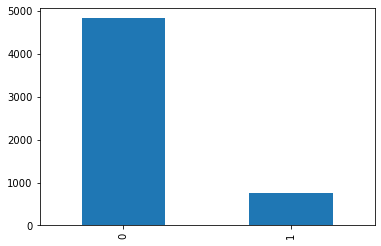

In [247]:
data.v1.value_counts().plot(kind='bar')

print('Non-Spam: ', data.v1.value_counts()[0])
print('Spam: ', data.v1.value_counts()[1])

Spam의 비율이 압도적으로 적음을 알 수 있음

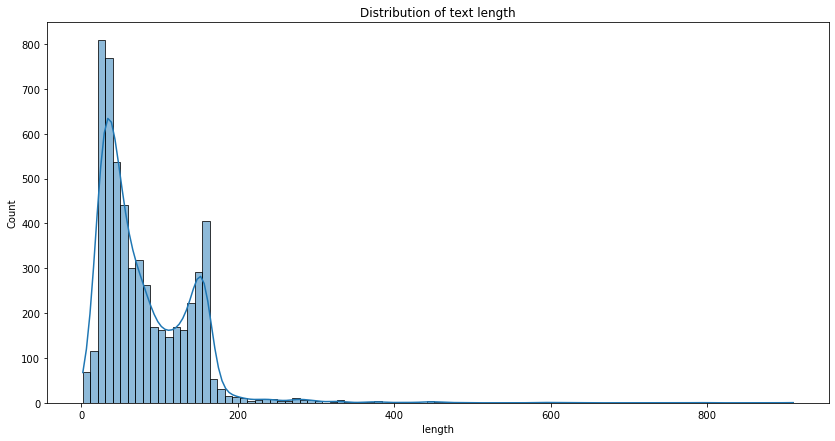

max: 910
min: 2
mean: 80.11880832735105


In [248]:
import seaborn as sns

plt.figure(figsize=(14,7))
data['length'] = data.v2.apply(lambda x: len(x))
sns.histplot(data=data.length, kde=True)
plt.title('Distribution of text length')
plt.show()

print(f'max: {data.length.max()}')
print(f'min: {data.length.min()}')
print(f'mean: {data.length.mean()}')

## Preprocessing

정규표현식을 활용한 정제 및 불용어 제거

In [249]:
stop_words = set(stopwords.words('english'))

def preprocess_words(x):
    x = x.lower()
    x = re.sub(r'\([^)]*\)', '', x)
    x = re.sub(r'\W', ' ', x)
    x = re.sub(r'\d', ' ', x)
    x = re.sub(r'\s+', ' ', x)
    x = re.sub(r'\W*\b\w{1,2}\b', ' ', x).strip()
    x = " ".join([t for t in word_tokenize(x) if t not in stop_words])
    return x

data['cleaned_v2'] = data.v2.apply(preprocess_words)

data

,v1,v2,length,cleaned_v2
0,0,"Go until jurong point, crazy.. Available only ...",111,jurong point crazy available bugis great world...
1,0,Ok lar... Joking wif u oni...,29,lar joking wif oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry wkly comp win cup final tkts may te...
3,0,U dun say so early hor... U c already then say...,49,dun say early hor already say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,nah think goes usf lives around though
...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,time tried contact pound prize claim easy call...
5568,0,Will Ì_ b going to esplanade fr home?,37,going esplanade home
5569,0,"Pity, * was in mood for that. So...any other s...",57,pity mood suggestions
5570,0,The guy did some bitching but I acted like i'd...,125,guy bitching acted like interested buying some...


토큰화 및 임베딩

In [250]:
# Word2Vec 모델 로드
# 보편적으로 가장 많이 사용하는 임베딩 모델이기 때문에 선택하게 됨.
word2vec_model = gensim.downloader.load('word2vec-google-news-300')

In [251]:
# 토크나이저 및 vocab 정의
# 파이토치에서 제공하는 기본 영어 토크나이저 사용
tokenizer = get_tokenizer("basic_english")

def yielder(dataset):
    for text in dataset:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yielder(data.cleaned_v2), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [252]:
# 텍스트 임베딩 진행

from tqdm import tqdm

vocab_size = len(vocab)
embedding_dim = word2vec_model.vectors.shape[1]
embedding_matrix = torch.zeros((vocab_size, embedding_dim))

for word, i in tqdm(vocab.get_stoi().items(), desc='Making Embedding Matrix'):
    try:
        embedding_matrix[i] = torch.tensor(word2vec_model[word])
    except KeyError:
        # Word2Vec의 vocab에 해당 단어가 없을 경우, 균등분포를 따르는 랜덤 가중치 값 생성
        embedding_matrix[i] = torch.tensor(np.random.uniform(-0.25, 0.25, embedding_dim))

Making Embedding Matrix:   0%|          | 0/7310 [00:00<?, ?it/s]

Making Embedding Matrix: 100%|██████████| 7310/7310 [00:00<00:00, 37215.73it/s]


CNN 기반 스팸문자 탐지 모델 구현

In [258]:
class SpamPrediction(nn.Module):
    def __init__(self, embedding_matrix, embedding_dim, num_filters, kernel_size, dr_ratio):
        super(SpamPrediction, self).__init__()

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.conv = nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=kernel_size)
        self.dropout = nn.Dropout(dr_ratio)
        self.max_pool = nn.MaxPool1d(kernel_size)
        self.fc = nn.Linear(num_filters * 6, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
    
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = torch.relu(x)
        x = self.max_pool(x)
        x = x.squeeze(2)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.sigmoid(x)

        return x

In [259]:
# GPU 사용

if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print(DEVICE)

cpu


## Training and Evaluation

In [260]:
# 하이퍼파라미터 설정

BATCH_SIZE = 128
EPOCH = 5
learning_rate = 1e-3
model = SpamPrediction(embedding_matrix, embedding_dim, 512, 10, 0.5).to(DEVICE)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [261]:
X = data.cleaned_v2.apply(lambda x: vocab(tokenizer(x)))
X = pad_sequence([torch.tensor(seq) for seq in X], batch_first=True, padding_value=0)

y = torch.tensor(data.v1, dtype=torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=42)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [262]:
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings("ignore")

def train(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct = 0
    total_recall = 0.0
    total_precision = 0.0
    total_f1 = 0.0
    for inputs, labels in tqdm(train_loader, desc='Training'):
        inputs.to(DEVICE)
        labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predicted = torch.round(outputs)
        correct += (predicted.squeeze(1) == labels).sum().item()

        # recall, precision, f1-score 계산
        recall, precision, f1, _ = precision_recall_fscore_support(
            labels.detach().numpy(), 
            predicted.squeeze(1).detach().numpy(), 
            average='binary'
            )
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    epoch_loss = total_loss / len(train_loader)
    epoch_acc = correct / len(train_loader.dataset) * 100
    epoch_recall = total_recall / len(train_loader)
    epoch_precision = total_precision / len(train_loader)
    epoch_f1 = total_f1 / len(train_loader)
    return epoch_loss, epoch_acc, epoch_recall, epoch_precision, epoch_f1

def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total_recall = 0.0
    total_precision = 0.0
    total_f1 = 0.0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validating'):
            inputs.to(DEVICE)
            labels.to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            total_loss += loss.item()
            predicted = torch.round(outputs)
            correct += (predicted.squeeze(1) == labels).sum().item()
            
            # recall, precision, f1-score 계산
            recall, precision, f1, _ = precision_recall_fscore_support(
                labels.detach().numpy(), 
                predicted.squeeze(1).detach().numpy(), 
                average='binary'
                )
            total_recall += recall
            total_precision += precision
            total_f1 += f1
        
    epoch_loss = total_loss / len(val_loader)
    epoch_acc = correct / len(val_loader.dataset) * 100
    epoch_recall = total_recall / len(val_loader)
    epoch_precision = total_precision / len(val_loader)
    epoch_f1 = total_f1 / len(val_loader)
    return epoch_loss, epoch_acc, epoch_recall, epoch_precision, epoch_f1

def evaluate(model, test_loader, criterion):
    model.train()
    total_loss = 0.0
    correct = 0
    total_recall = 0.0
    total_precision = 0.0
    total_f1 = 0.0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Evaluating'):
            inputs.to(DEVICE)
            labels.to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            total_loss += loss.item()
            predicted = torch.round(outputs)
            correct += (predicted.squeeze(1) == labels).sum().item()
            
            # recall, precision, f1-score 계산
            recall, precision, f1, _ = precision_recall_fscore_support(
                labels.detach().numpy(), 
                predicted.squeeze(1).detach().numpy(), 
                average='binary'
                )
            total_recall += recall
            total_precision += precision
            total_f1 += f1
        
    epoch_loss = total_loss / len(test_loader)
    epoch_acc = correct / len(test_loader.dataset) * 100
    epoch_recall = total_recall / len(test_loader)
    epoch_precision = total_precision / len(test_loader)
    epoch_f1 = total_f1 / len(test_loader)
    return epoch_loss, epoch_acc, epoch_recall, epoch_precision, epoch_f1


train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []
train_recall_history = []
val_recall_history = []
train_precision_history = []
val_precision_history = []
train_f1_history = []
val_f1_history = []

# 학습 및 평가
for epoch in range(1, EPOCH+1):
    train_loss, train_acc, train_recall, train_precision, train_f1 = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc, val_recall, val_precision, val_f1 = validate(model, val_loader, criterion)
    print(f'Epoch {epoch}/{EPOCH}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train Recall: {train_recall:.4f}, Train Precision: {train_precision:.4f}, Train F1: {train_f1:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Recall: {val_recall:.4f}, Val Precision: {val_precision:.4f}, Val F1: {val_f1:.4f}')

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)

print('\n')
test_loss, test_acc, test_recall, test_precision, test_f1 = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test Recall: {test_recall:.4f}, Test Precision: {test_precision:.4f}, Test F1: {test_f1:.4f}')


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.38it/s]


Epoch 1/5, Train Loss: 0.2956, Train Acc: 88.6957, Train Recall: 0.5300, Train Precision: 0.3619, Train F1: 0.3992, Val Loss: 0.1567, Val Acc: 96.0762, Val Recall: 0.8485, Val Precision: 0.7642, Val F1: 0.8006


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.07it/s]


Epoch 2/5, Train Loss: 0.1122, Train Acc: 96.6900, Train Recall: 0.9358, Train Precision: 0.8188, Train F1: 0.8692, Val Loss: 0.0927, Val Acc: 97.0852, Val Recall: 0.9369, Val Precision: 0.7704, Val F1: 0.8410


Validating: 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


Epoch 3/5, Train Loss: 0.0659, Train Acc: 97.9523, Train Recall: 0.9542, Train Precision: 0.8916, Train F1: 0.9206, Val Loss: 0.0787, Val Acc: 97.8700, Val Recall: 0.9484, Val Precision: 0.8267, Val F1: 0.8814


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.24it/s]


Epoch 4/5, Train Loss: 0.0469, Train Acc: 98.4853, Train Recall: 0.9658, Train Precision: 0.9204, Train F1: 0.9413, Val Loss: 0.0745, Val Acc: 97.8700, Val Recall: 0.9099, Val Precision: 0.8722, Val F1: 0.8886


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.25it/s]


Epoch 5/5, Train Loss: 0.0311, Train Acc: 99.1304, Train Recall: 0.9783, Train Precision: 0.9546, Train F1: 0.9659, Val Loss: 0.0684, Val Acc: 98.0942, Val Recall: 0.9520, Val Precision: 0.8540, Val F1: 0.8987




Evaluating: 100%|██████████| 9/9 [00:01<00:00,  6.65it/s]

Test Loss: 0.0911, Test Acc: 97.3991, Test Recall: 0.9636, Test Precision: 0.8421, Test F1: 0.8973


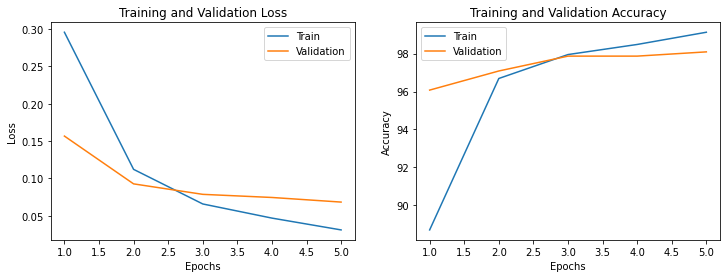

In [263]:
def plot_metrics(train_loss, val_loss, train_acc, val_acc):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train')
    plt.plot(epochs, val_loss, label='Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train')
    plt.plot(epochs, val_acc, label='Validation')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


plot_metrics(train_loss_history, val_loss_history, train_acc_history, val_acc_history)

Evaluating: 100%|██████████| 9/9 [00:01<00:00,  6.47it/s]


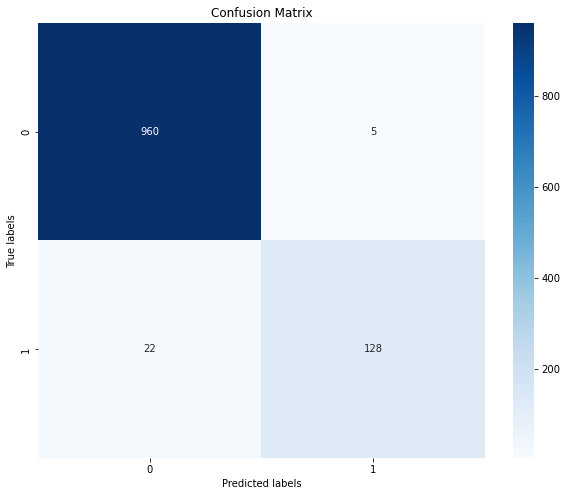

In [264]:
from sklearn.metrics import confusion_matrix

def evaluate_confusion_matrix(model, test_loader):
    model.eval()
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Evaluating'):
            inputs.to(DEVICE)
            labels.to(DEVICE)

            outputs = model(inputs)
            predicted = torch.round(outputs).squeeze(1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
        
    cm = confusion_matrix(true_labels, predicted_labels)
    return cm

# 테스트 데이터에 대한 confusion matrix 생성
conf_matrix = evaluate_confusion_matrix(model, test_loader)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

accuracy 값에 비해 precision 값이 상당히 낮게 나타나는 것을 알 수 있음. 이는 양성 클래스의 수가 지나치게 적기 때문에 발생한 문제로, class weight 등을 설정하여 손실함수에 전달하는 등의 방법을 활용하면 성능을 조금 더 좋게 개선할 수 있을 것으로 보임